In [3]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from data_cleaner import *

In [4]:
df_fcu_sth_raw = pd.read_csv('data/Gnd floor FCU Sth 16032020.csv')
df_fcu_nth_raw = pd.read_csv('data/Gnd floor FCU North 16032020.csv')
df_ahu_raw = pd.read_csv('data/Gnd AHU multi list 16032020.csv')
df_chiller_boiler_raw = pd.read_csv('data/more_Data/chillers boilers thermal Feb 23032020.csv')
room_info_raw = pd.read_csv('data/Room Details.csv')

df_ltb_temps = create_temp_df(df_fcu_sth_raw, df_fcu_nth_raw, df_ahu_raw)
df_chiller_boiler_power = create_chiller_boiler_power_df(df_chiller_boiler_raw)
df_room_info = create_room_info_df(room_info_raw)

In [5]:
# Dictionary for processing data:
ahu_lookup = {
    'AHU-01': 'AHU-01 Internal ZnTmp_1',
    'AHU-B1-01': 'AHU-B1-01 ZnTmp_1',
    'AHU-B1-02': 'AHU-B1-02 ZnTmp_1'
}

In [6]:
# @param room_dimen_list a panda dataframe object frame.
# @param time_step integer value of the number of minutes between each temperature reading.
# @param time_frame String list input of the hours of interest.
# @param room_height float value for the height of the wall with respect to the room ceiling.
# @param Cp dry air specific heat constant (J*g/K)
# @param rho density of air
# Output is in kiloJoules.
# Assumptions: wall height is approx. one storey which is 3.3m
def energyLossRoom(room, time_step=15, time_frame=["06:00", "18:00"], room_height=3.3, Cp=1.00, rho=1275):
    room_height = room_height
    coeff_air = Cp
    update_freq = time_step
    room_area = room[2]
    if room[3] == 0:
        return 0
    wall_area = room[3]*room_height
    current_room_unit = room[1]
    temp_list = getTempRoom(current_room_unit, update_freq, time_frame)
    return (temp_list)*coeff_air*rho*room_area/1000

# @brief Calclulate the temperature difference of the room given the unit name. Outputs in percentage.
# @param current_room_unit String input of the Cooling unit for the respective room
# @param time_period Integer input of the time_frame of interest.
# @param time_frame String list input of the hours of interest.
def getTempRoom(current_room_unit, update_freq, time_frame):
    ahu_fcu_sample = df_ltb_temps.resample(str(update_freq)+'min', on='Timestamp').first()
    # Isolate to the specific operating hours of interest:
    sampled_period = ahu_fcu_sample.between_time(time_frame[0], time_frame[1])
    if 'FCU' in current_room_unit:
        temp_idx = current_room_unit + ' ZnTmp'
    else:
        temp_idx = ahu_lookup[current_room_unit]
    # Calculate difference between each cell:
    change_in_temp = sampled_period[temp_idx].diff()
    return change_in_temp

In [7]:
# @brief: Calculates the energy from all rooms. To use individual rooms, use the energyLossRoom function
def energyLossAllRooms():
    energy_loss_dict = {}
    for _, current_room in df_room_info.iterrows():
        energy_loss = energyLossRoom(current_room)
        energy_loss_dict[current_room[0]] = energy_loss
    return pd.DataFrame(data=energy_loss_dict)

In [8]:
# @todo: I'm not sure why it's giving zeros for a few of these data points, but perhaps you can have a look at it
# and sanity check since I'm tired haha
energy_loss_df = energyLossAllRooms()
energy_loss_df

,G31,G01,G02,G03,G21,G23,G81,G54,G55,G56,G57,G58,G60,G61,G62
Timestamp,,,,,,,,,,,,,,,
2020-02-02 06:00:00,NaN,NaN,NaN,NaN,0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-02 06:15:00,-20.835157,-2.48574,-1.125442,-6.126375,0,0,0.000000,0,-2.527050,-2.453610,-2.184585,0.00000,0.000000,-1.186388,0.000000
2020-02-02 06:30:00,-20.835158,-3.72861,-2.250885,-9.189563,0,0,-23.632762,0,-1.263525,-3.680415,-1.092293,-1.04856,-2.398530,-2.372775,-1.300755
2020-02-02 06:45:00,-20.835158,-1.24287,-1.125443,-3.063187,0,0,0.000000,0,-1.263525,-2.453610,-2.184585,-1.04856,-2.398530,0.000000,-1.300755
2020-02-02 07:00:00,0.000000,-1.24287,0.000000,-6.126375,0,0,-23.632763,0,-1.263525,-1.226805,-1.092292,-1.04856,-1.199265,0.000000,-1.300755
2020-02-02 07:15:00,0.000000,-2.48574,-1.125442,-6.126375,0,0,0.000000,0,-1.263525,-1.226805,-2.184585,-1.04856,-1.199265,0.000000,1.300755
2020-02-02 07:30:00,-20.835158,0.00000,-2.250885,-3.063187,0,0,0.000000,0,-1.263525,0.000000,0.000000,0.00000,1.199265,1.186388,0.000000
2020-02-02 07:45:00,0.000000,-1.24287,-2.250885,0.000000,0,0,-23.632763,0,0.000000,1.226805,0.000000,1.04856,3.597795,2.372775,2.601510
2020-02-02 08:00:00,0.000000,-1.24287,-2.250885,-6.126375,0,0,0.000000,0,-1.263525,3.680415,1.092293,0.00000,4.797060,0.000000,1.300755


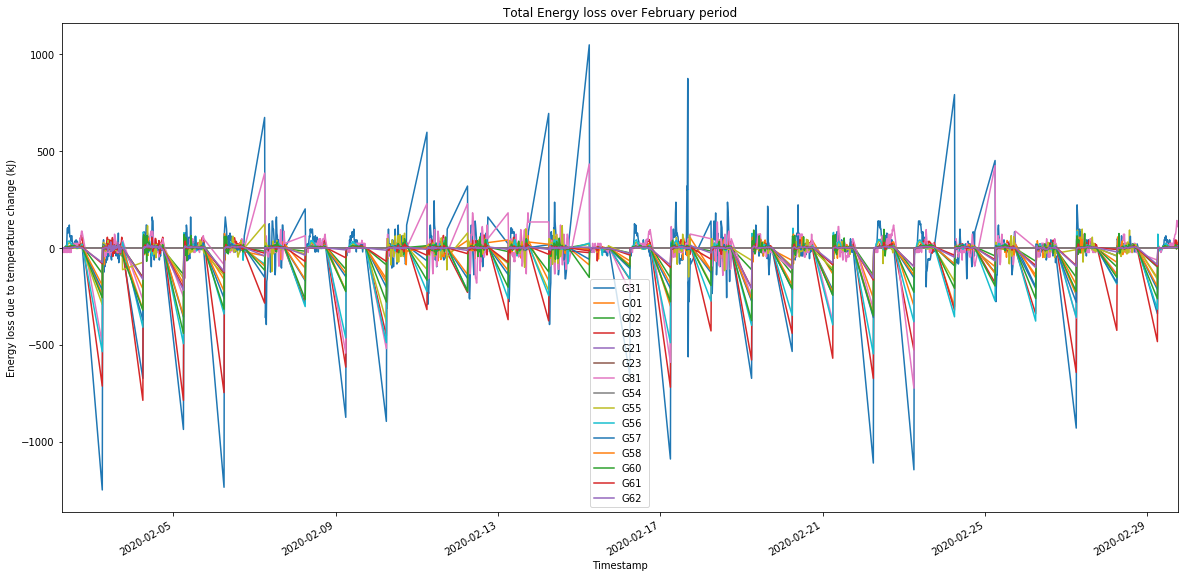

In [67]:
# Plot the output for the energy loss from temperature change
# @note You can use the below plot to plot the entire thing in time series. 
fig= plt.figure(figsize=(20,10))
ax = plt.gca()
ax.set_title("Total Energy loss over February period")
ax.set_ylabel("Energy loss due to temperature change (kJ)")
ax.set_xlabel("Time Index")
for col in energy_loss_df.columns:
    energy_loss_df[col].plot(kind='line', ax=ax, legend=True)
plt.show()